In [9]:
import numpy as np
import pandas as pd
import os
import sqlite3 as sql
import requests
from bs4 import BeautifulSoup
import statsmodels.formula.api as statapi
import matplotlib as mpl 
import matplotlib.pyplot as plt
import csv
from sklearn.linear_model import LinearRegression as linreg
import seaborn as sb

In [29]:
# All of the data from https://www.kaggle.com/datasets/datasnaek/chess?resource=download
entire_dataset = pd.read_csv("./games.csv")
# Pulled the headers from the CSV file
# dataset_headers raentire_dataset.columns
print(entire_dataset.columns)


Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')


In [11]:
print(entire_dataset.size)

320928


In [12]:
#Only games that were rated, not "casual"
rated_dataset = entire_dataset[entire_dataset["rated"] == True]


In [13]:
# print(len(rated_dataset))
display(rated_dataset.head())

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5
6,qwU9rasv,True,1.504230e+12,1.504230e+12,33,resign,white,10+0,capa_jr,1520,daniel_likes_chess,1423,d4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 ...,D00,Blackmar-Diemer Gambit: Pietrowsky Defense,10


In [14]:
#This code block sums up the number of wins for each white, black, and tie and compiles a dictionary for all of the openings
#         num wins for black | num wins for white | num ties
# opening1
# opening2
# opening3
openings = {}
# opening_freq = {}
for i, row in rated_dataset.iterrows():
    opening_name = row[14]
    opening_eco = row[13]
    winner = row[6]
    openings.setdefault(opening_name, (opening_eco, [0, 0, 0, 0]))  # white, black, tie, freq (white+black+tie=freq)
    
    if winner == 'white':
        openings[opening_name][1][0] += 1
    elif winner == 'black':
        openings[opening_name][1][1] += 1
    elif winner == 'draw':
        openings[opening_name][1][2] += 1
    openings[opening_name][1][3] += 1

# openings = sorted(openings.keys())
display(openings)

{'Nimzowitsch Defense: Kennedy Variation': ('B00', [1, 2, 0, 3]),
 "King's Pawn Game: Leonardis Variation": ('C20', [54, 53, 2, 109]),
 "Queen's Pawn Game: Zukertort Variation": ('D02', [47, 32, 5, 84]),
 'Philidor Defense': ('C41', [68, 35, 6, 109]),
 'Blackmar-Diemer Gambit: Pietrowsky Defense': ('D00', [2, 0, 0, 2]),
 'Italian Game: Schilling-Kostic Gambit': ('C50', [11, 20, 3, 34]),
 'Scandinavian Defense: Mieses-Kotroc Variation': ('B01', [129, 73, 5, 207]),
 "English Opening: King's English Variation |  Reversed Closed Sicilian": ('A25',
  [13, 4, 0, 17]),
 'Sicilian Defense: Smith-Morra Gambit #2': ('B21', [45, 42, 5, 92]),
 "Queen's Pawn Game: Chigorin Variation": ('D01', [84, 91, 5, 180]),
 'Scotch Game: Haxo Gambit': ('C45', [8, 1, 0, 9]),
 'Slav Defense': ('D10', [13, 17, 3, 33]),
 "Queen's Gambit Refused: Marshall Defense": ('D06', [75, 28, 1, 104]),
 'Sicilian Defense: Canal Attack |  Main Line': ('B52', [10, 15, 0, 25]),
 'Sicilian Defense': ('B27', [125, 150, 8, 283]),
 

In [15]:
def top_n(num, d):
    return sorted(d.items(), key=lambda x:x[1][1][3], reverse=True)[0:num]

In [16]:
# x values (bins) for all histograms
sorted_openings = sorted(openings)
top_n_openings = top_n(50, openings)
top_n_openings_df = pd.DataFrame(columns=['Opening Name', 'Opening ECO', 'White Wins', 'Black Wins', 'Draws', 'Frequency'])
for i, opening in enumerate(top_n_openings):
    eco, data = openings[opening[0]]
    white, black, tie, freq = data
    top_n_openings_df.loc[i] = [opening[0], eco, white, black, tie, freq]
display(top_n_openings_df)

x_values = [ele[0] for ele in top_n_openings]
# display(top_n_openings)


,Opening Name,Opening ECO,White Wins,Black Wins,Draws,Frequency
0,Van't Kruijs Opening,A00,97,198,13,308
1,Sicilian Defense,B27,125,150,8,283
2,Sicilian Defense: Bowdler Attack,B20,97,139,12,248
3,French Defense: Knight Variation,C00,116,100,13,229
4,Scotch Game,C44,112,99,8,219
5,Scandinavian Defense: Mieses-Kotroc Variation,B01,129,73,5,207
6,Queen's Pawn Game: Mason Attack,D00,92,86,9,187
7,Scandinavian Defense,B01,80,96,10,186
8,Horwitz Defense,A40,96,83,5,184
9,Queen's Pawn Game: Chigorin Variation,D01,84,91,5,180


/var/folders/m0/7mtk_4hd41b91xmjskxcdf1r0000gn/T/ipykernel_99704/3151363888.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_w.set_xticklabels(top_n_openings_df['Opening Name'], rotation=90)


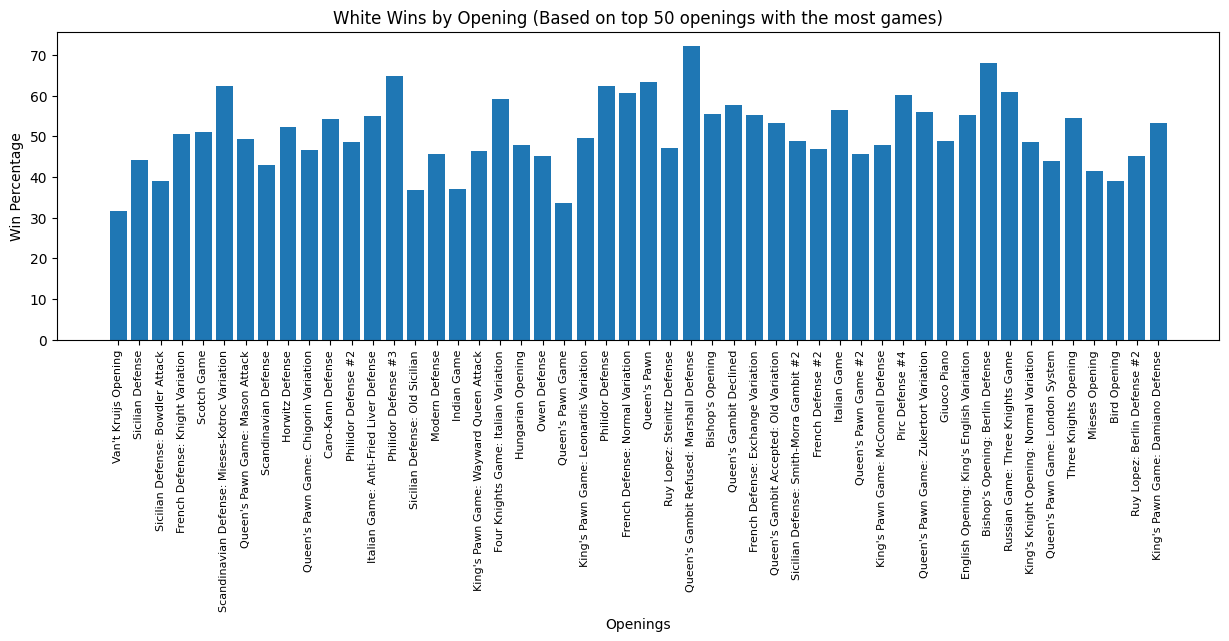

In [17]:
# make histogram for white win percentage
fig_w, ax_w = plt.subplots(figsize=(15, 4))

# Create a bar chart
white_win_percentage = 100*(top_n_openings_df['White Wins'].astype(float)/top_n_openings_df['Frequency'].astype(float))
ax_w.bar(top_n_openings_df['Opening Name'], white_win_percentage)
# Set labels and title
ax_w.set_xticklabels(top_n_openings_df['Opening Name'], rotation=90)
plt.xticks(fontsize=8)  #, width=10)
# ax_w.tick_params(axis='x', which='major', pad=.5)
ax_w.set_xlabel('Openings')
ax_w.set_ylabel('Win Percentage')
ax_w.set_title('White Wins by Opening (Based on top 50 openings with the most games)')
plt.show()

# for i, row in top_n_openings_df.iterrows():
#     name = row[0]
#     eco = row[1]
#     print(f'{i+1})', eco, '-->', name)

/var/folders/m0/7mtk_4hd41b91xmjskxcdf1r0000gn/T/ipykernel_99704/2713126994.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_w.set_xticklabels(top_n_openings_df['Opening Name'], rotation=90)


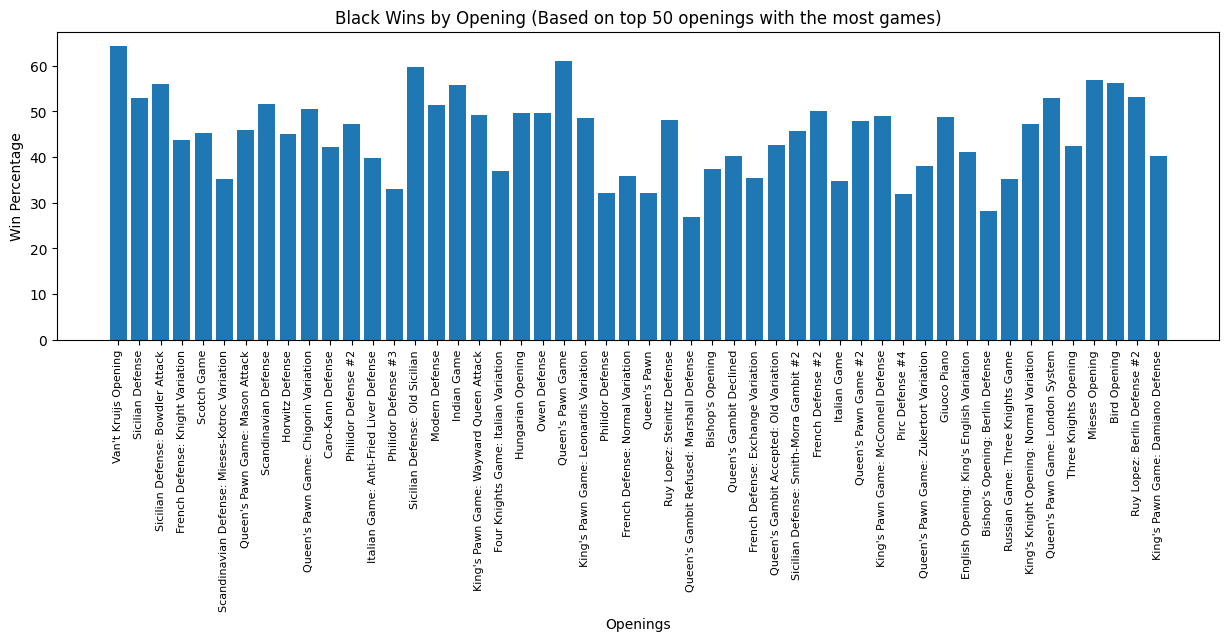

In [18]:
# make histogram for black win percentage
fig_w, ax_w = plt.subplots(figsize=(15, 4))

# Create a bar chart
black_win_percentage = 100*(top_n_openings_df['Black Wins'].astype(float)/top_n_openings_df['Frequency'].astype(float))
ax_w.bar(top_n_openings_df['Opening Name'], black_win_percentage)
# Set labels and title
ax_w.set_xticklabels(top_n_openings_df['Opening Name'], rotation=90)
plt.xticks(fontsize=8)  #, width=10)
# ax_w.tick_params(axis='x', which='major', pad=.5)
ax_w.set_xlabel('Openings')
ax_w.set_ylabel('Win Percentage')
ax_w.set_title('Black Wins by Opening (Based on top 50 openings with the most games)')
plt.show()

/var/folders/m0/7mtk_4hd41b91xmjskxcdf1r0000gn/T/ipykernel_99704/2266269084.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_w.set_xticklabels(top_n_openings_df['Opening Name'], rotation=90)


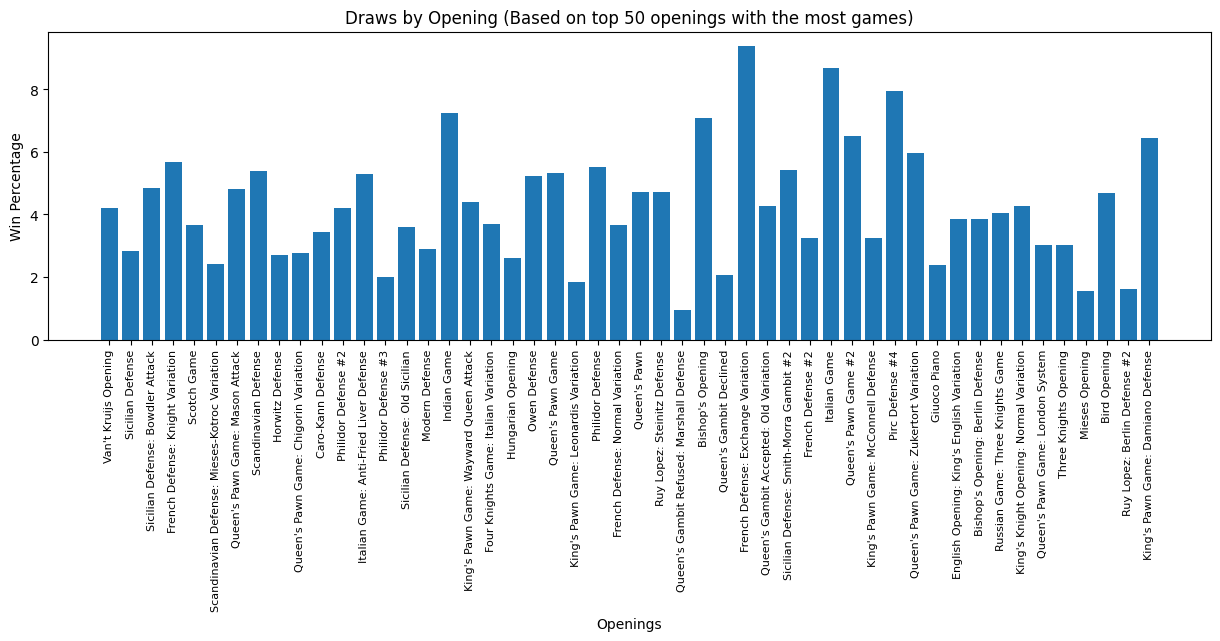

In [19]:
# make histogram for draw percentage
fig_w, ax_w = plt.subplots(figsize=(15, 4))

# Create a bar chart
draw_percentage = 100*(top_n_openings_df['Draws'].astype(float)/top_n_openings_df['Frequency'].astype(float))
ax_w.bar(top_n_openings_df['Opening Name'], draw_percentage)
# Set labels and title
ax_w.set_xticklabels(top_n_openings_df['Opening Name'], rotation=90)
plt.xticks(fontsize=8)  #, width=10)
# ax_w.tick_params(axis='x', which='major', pad=.5)
ax_w.set_xlabel('Openings')
ax_w.set_ylabel('Win Percentage')
ax_w.set_title('Draws by Opening (Based on top 50 openings with the most games)')
plt.show()

# for i, row in top_n_openings_df.iterrows():
#     name = row[0]
#     eco = row[1]
#     print(f'{i+1})', eco, '-->', name)

In [20]:
white_queen = []
black_queen = []
white_qwp = {}
black_qwp = {}
for i, row in rated_dataset.iterrows():
    moves = row[12].split()
    winner = row[6]
    black_count = 0
    white_count = 0     
    w_queen_found = False
    b_queen_found = False
    for j, move in enumerate(moves):
        if j % 2 == 0: # even i
            if move[0] == 'Q':
                w_queen_found = True                
            if not w_queen_found and move[0] != 'Q':
                white_count += 1
        else: # odd is black
            if move[0] == 'Q':
                b_queen_found = True
            if not b_queen_found and move[0] != 'Q':
                black_count += 1    
        length = len(moves)
        if length % 2 == 0:
            if white_count == length // 2:
                 white_count = 0
            if black_count == length // 2:
                 black_count = 0
        else:
            if white_count == (length // 2) + 1:
                white_count = 0
            if black_count == length // 2:
                 black_count = 0   
    white_qwp.setdefault(white_count, [0, 0])  # white wins, total games
    white_qwp[white_count][1] += 1
    if winner == 'white':
        white_qwp[white_count][0] += 1
    black_qwp.setdefault(black_count, [0, 0])
    black_qwp[black_count][1] += 1
    if winner == 'black':
        black_qwp[black_count][0] += 1
    # white_queen.append(white_count)
    # black_queen.append(black_count)entire_dataset

In [21]:
print(white_qwp.keys())
print(black_qwp.keys())

white_win_perc = [100*float(white_qwp[key][0]/white_qwp[key][1]) for key in white_qwp]
black_win_perc = [100*float(black_qwp[key][0]/black_qwp[key][1]) for key in black_qwp]

print(white_win_perc)
print(black_win_perc)

dict_keys([5, 24, 13, 12, 9, 4, 0, 2, 7, 6, 16, 14, 19, 10, 8, 11, 1, 22, 15, 21, 3, 20, 23, 26, 17, 18, 39, 25, 31, 43, 34, 29, 33, 28, 27, 30, 53, 46, 56, 32, 48, 58, 54, 35, 45, 60, 59, 44, 42, 57, 52, 70, 73, 49, 41, 50])
dict_keys([0, 13, 5, 10, 11, 1, 12, 9, 7, 18, 15, 2, 4, 8, 3, 17, 29, 19, 6, 16, 14, 23, 20, 28, 58, 21, 24, 22, 49, 31, 25, 30, 42, 39, 27, 26, 36, 60, 41, 34, 55, 47, 32, 38, 46, 52, 56, 45, 72, 43, 33, 57, 37, 65, 48, 77, 50])
[49.66814159292036, 50.0, 50.83102493074792, 48.44444444444444, 50.45289855072463, 51.05263157894737, 44.03567447045708, 46.666666666666664, 51.288888888888884, 50.811359026369175, 51.470588235294116, 48.67807153965785, 45.28301886792453, 50.58939096267191, 51.74693106704438, 51.96687370600414, 48.529411764705884, 44.73684210526316, 51.689189189189186, 49.673202614379086, 52.59259259259259, 56.25, 57.14285714285714, 57.14285714285714, 49.876543209876544, 48.45679012345679, 100.0, 53.06122448979592, 66.66666666666666, 100.0, 42.85714285714

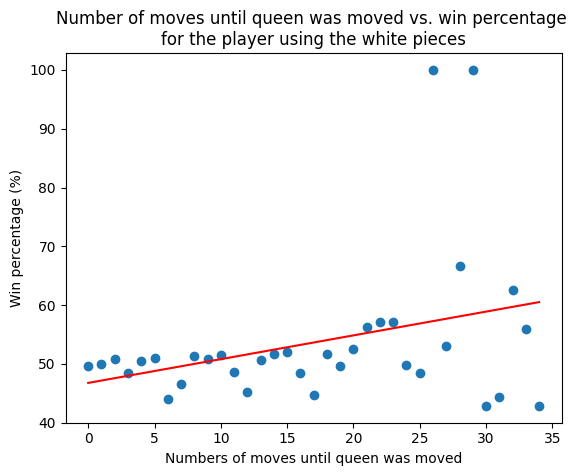

In [22]:
# create scatter plot for white

white_xvals = list(white_qwp.keys())
white_xvals.sort()
w_first35 = white_xvals[0:35]
w_first35_2D = np.array(w_first35).reshape((-1, 1))  # reshape data to fit x axis
w_model = linreg().fit(w_first35_2D, white_win_perc[0:35])
w_preds = w_model.predict(w_first35_2D)
plt.scatter(w_first35, white_win_perc[0:35])
plt.plot(w_first35, w_preds, color='red')
plt.xlabel('Numbers of moves until queen was moved')
plt.ylabel('Win percentage (%)')
plt.title('Number of moves until queen was moved vs. win percentage \nfor the player using the white pieces')
plt.show()

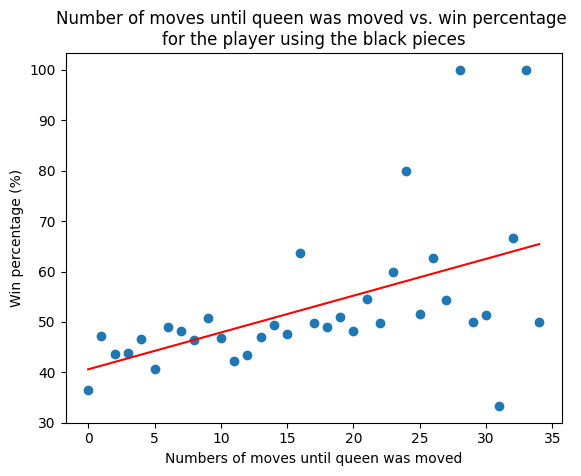

In [23]:
# create scatter plot for black
black_xvals = list(black_qwp.keys())
black_xvals.sort()
b_first35 = black_xvals[0:35]
b_first35_2D = np.array(b_first35).reshape((-1, 1))  # reshape data to fit x axis
b_model = linreg().fit(b_first35_2D, black_win_perc[0:35])
b_preds = b_model.predict(b_first35_2D)
plt.scatter(b_first35, black_win_perc[0:35])
plt.plot(b_first35, b_preds, color='red')
plt.xlabel('Numbers of moves until queen was moved')
plt.ylabel('Win percentage (%)')
plt.title('Number of moves until queen was moved vs. win percentage \nfor the player using the black pieces')
plt.show()

[2.8977680745453753, 2.8254240638334025, 3.252246576789716, 0.4614636726946202, 2.0657153611832015, 2.261245971614322, -5.159913554667575, -2.9331237762496087, 1.2848960281810022, 0.40316374786967657, 0.6581905390030087, -2.5385285744248733, -6.3377836639498, -1.435613986994042, -0.6822763004131787, -0.8665360792450372, -4.708200438334899, -8.904972515569241, -2.356827849434822, -4.777016842036538, -2.261829281614645, 0.9913757080011507, 1.4800304330666805, 1.0758280152750643, -6.594688335497139, -8.418643839708508, 42.72036361904309, -4.622614308952606, 8.578625450126523, 41.50775636566825, -16.039303194980505, -14.856204025470532, 2.795149112293416, -4.109053305498193, -17.656112866146955]


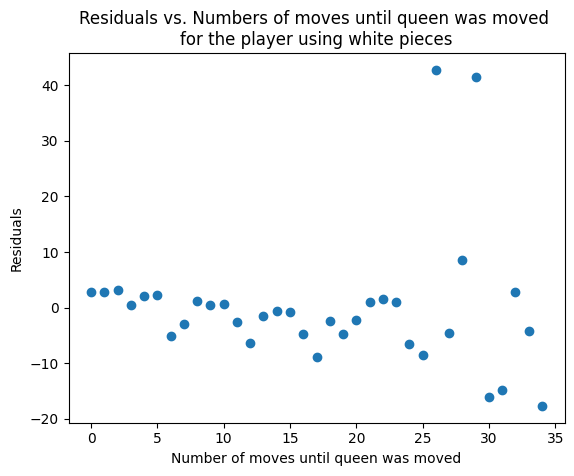

In [24]:
# create new residuals column by subtracting predicted values from actual values
# data['residuals'] = data['lifeExp'] - model.predict()  
w_residuals = []
for i, move in enumerate(w_first35):
    residual = white_win_perc[i] - w_preds[i]
    w_residuals.append(residual)
print(w_residuals)
# residual data
# sb.violinplot(x=w_first35, y=w_residuals)
plt.scatter(w_first35, w_residuals)
plt.xlabel("Number of moves until queen was moved")
plt.ylabel('Residuals')
plt.title('Residuals vs. Numbers of moves until queen was moved \nfor the player using white pieces')
plt.show()


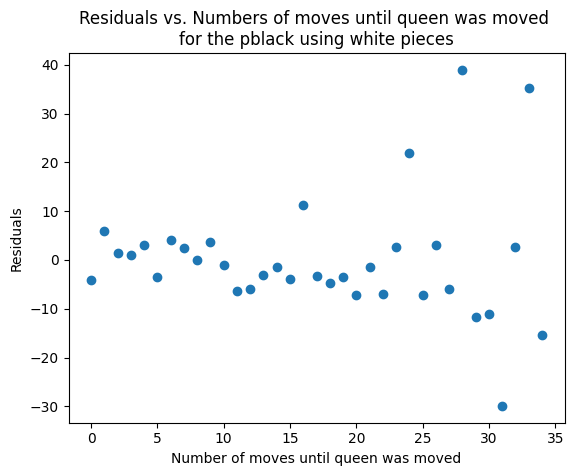

In [25]:
b_residuals = []
for i, move in enumerate(b_first35):
    residual = black_win_perc[i] - b_preds[i]
    b_residuals.append(residual)

plt.scatter(b_first35, b_residuals)
plt.xlabel("Number of moves until queen was moved")
plt.ylabel('Residuals')
plt.title('Residuals vs. Numbers of moves until queen was moved \nfor the pblack using white pieces')
plt.show()

Null Hypothesis: when you move your queen has no significant effect on win percentage

Alternative Hypothesis: when you move your queen has a significant effect on win percentage

In [26]:
white_queen_wp_df = pd.DataFrame(columns=['Num_Moves', 'Win_Percentage'])
for i, moves in enumerate(w_first35):
    white_queen_wp_df.loc[i] = [moves, white_win_perc[i]]
# display(white_queen_wp_df)

model2 = statapi.ols(formula="Num_Moves ~ Win_Percentage", data=white_queen_wp_df).fit()

# print results of Ordinary Least Squares model
print(model2.summary())
print(f'\np-values: \n{model2.pvalues}')

                            OLS Regression Results                            
Dep. Variable:              Num_Moves   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     3.981
Date:                Mon, 08 May 2023   Prob (F-statistic):             0.0543
Time:                        15:32:15   Log-Likelihood:                -128.61
No. Observations:                  35   AIC:                             261.2
Df Residuals:                      33   BIC:                             264.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.7136      7.350      0.

In [27]:
print(model2.f_test(np.identity(len(model2.params))))

<F test: F=54.380333004509694, p=3.5876512295876294e-11, df_denom=33, df_num=2>


In [94]:
# [{num pieces developed: int, has player castled: bool, num pieces moved more than once: int, has_won: bool}]
# get info of first 7 moves
# features to extract: # of pieces developed, whether a player has castled, and whether the queen was moved in the first 7 moves
games_move_info = []

for i, row in entire_dataset.iterrows():
    white_game_data = {}
    black_game_data = {}
    # white_pieces_dev = 0
    # black_pieces_dev = 0
    # white_castled = False
    # black_castled = False
    # white_queen_moved = False
    # black_queen_moved = False
    white_game_data.setdefault("num_pieces_developed", 0)
    white_game_data.setdefault("num_pieces_taken", 0)
    white_game_data.setdefault("num_pieces_lost", 0)
    white_game_data.setdefault("has_castled", 0)
    white_game_data.setdefault("has_queen_moved", 0)
    white_game_data.setdefault("has_won", 1)
    black_game_data.setdefault("num_pieces_developed", 0)
    black_game_data.setdefault("num_pieces_taken", 0)
    black_game_data.setdefault("num_pieces_lost", 0)
    black_game_data.setdefault("has_castled", 0)
    black_game_data.setdefault("has_queen_moved", 0)
    black_game_data.setdefault("has_won", 0)
    move_split = row["moves"].split(" ")
    # white_pieces_to_move = ["white rook", "black rook", "white knight", "black knight", "white bishop", "black bishop", "queen", "king"] #black squared pieces and white squared pieces
    # black_pieces_to_move = ["white rook", "black rook", "white knight", "black knight", "white bishop", "black bishop", "queen", "king"] #black squared pieces and white squared pieces
    
    if len(move_split) >= 14:
        for j, move in enumerate(move_split[0:14]):
            if j % 2 == 0: # whites move
                if move == "O-O" or move == "O-O-O": # check if castled
                    white_castled = 1
                if move[0] == "B" or move[0] == "N" or move[0] == "R":
                    white_game_data["num_pieces_developed"] += 1
                if move[0] == "Q":
                    white_game_data["has_queen_moved"] = 1
                if "x" in move:
                    white_game_data["num_pieces_taken"] += 1
                    black_game_data["num_pieces_lost"] += 1
            else: # blacks move
                if move == "O-O" or move == "O-O-O":
                    black_castled = 1
                if move[0] == "B" or move[0] == "R" or move[0] == "N":
                    black_game_data["num_pieces_developed"] += 1
                if move[0] == "Q":
                    black_game_data["has_queen_moved"] = 1
                if "x" in move:
                    black_game_data["num_pieces_taken"] += 1
                    white_game_data["num_pieces_lost"] += 1
    if(row["winner"] == "white"):
         white_game_data["has_won"] = 1
    elif(row["winner"] == "black"):
        black_game_data["has_won"] = 1
    games_move_info.append(white_game_data)
    games_move_info.append(black_game_data)
display(games_move_info)
df = pd.DataFrame(games_move_info)
print(df)

[{'num_pieces_developed': 0,
  'num_pieces_taken': 0,
  'num_pieces_lost': 0,
  'has_castled': 0,
  'has_queen_moved': 0,
  'has_won': 1},
 {'num_pieces_developed': 0,
  'num_pieces_taken': 0,
  'num_pieces_lost': 0,
  'has_castled': 0,
  'has_queen_moved': 0,
  'has_won': 0},
 {'num_pieces_developed': 0,
  'num_pieces_taken': 2,
  'num_pieces_lost': 3,
  'has_castled': 0,
  'has_queen_moved': 1,
  'has_won': 1},
 {'num_pieces_developed': 4,
  'num_pieces_taken': 3,
  'num_pieces_lost': 2,
  'has_castled': 0,
  'has_queen_moved': 0,
  'has_won': 1},
 {'num_pieces_developed': 3,
  'num_pieces_taken': 1,
  'num_pieces_lost': 0,
  'has_castled': 0,
  'has_queen_moved': 0,
  'has_won': 1},
 {'num_pieces_developed': 1,
  'num_pieces_taken': 0,
  'num_pieces_lost': 1,
  'has_castled': 0,
  'has_queen_moved': 0,
  'has_won': 0},
 {'num_pieces_developed': 4,
  'num_pieces_taken': 0,
  'num_pieces_lost': 0,
  'has_castled': 0,
  'has_queen_moved': 0,
  'has_won': 1},
 {'num_pieces_developed': 4

       num_pieces_developed  num_pieces_taken  num_pieces_lost  has_castled  \
0                         0                 0                0            0   
1                         0                 0                0            0   
2                         0                 2                3            0   
3                         4                 3                2            0   
4                         3                 1                0            0   
...                     ...               ...              ...          ...   
40111                     3                 0                0            0   
40112                     0                 2                2            0   
40113                     4                 2                2            0   
40114                     4                 0                0            0   
40115                     3                 0                0            0   

       has_queen_moved  has_won  
0                

In [95]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# # Load the data
# data = pd.read_csv("./games.csv")

# Extract the features

X = df[['num_pieces_developed', 'has_castled', 'has_queen_moved', "num_pieces_lost", "num_pieces_taken"]]
y = df['has_won']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train a logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Get predicted probabilities for the test set
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Print coefficients and intercept
coefficients = clf.coef_
print(coefficients)
intercept = clf.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)

def sigmoid(coefficients, intercept, features):
    z = np.dot(coefficients, features) + intercept
    return 1 / (1 + np.exp(-z))

def log_loss(coefficients, intercept, features, label):
    p = sigmoid(coefficients, intercept, features)
    return -label * np.log(p) - (1 - label) * np.log(1 - p)

def sgd(X_train, y_train, learning_rate=0.01, num_iterations=1000):
    num_features = X_train.shape[1]
    coefficients = np.zeros(num_features)
    intercept = 0
    for i in range(num_iterations):
        random_index = np.random.randint(0, len(X_train))
        x_i = X_train.iloc[random_index]
        y_i = y_train.iloc[random_index]
        z = np.dot(coefficients, x_i) + intercept
        p = sigmoid(coefficients, intercept, x_i)
        gradient = (p - y_i) * x_i
        coefficients -= learning_rate * gradient
        intercept -= learning_rate * (p - y_i)
    return coefficients, intercept

coefficients, intercept = sgd(X_train, y_train, learning_rate=0.01, num_iterations=1000)

y_pred_proba = sigmoid(coefficients, intercept, X_test.T)
y_pred = np.round(y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7218344965104686
[[ 0.08672636  0.         -0.03894869  0.19470181 -0.19652971]]
Coefficients: [[ 0.08672636  0.         -0.03894869  0.19470181 -0.19652971]]
Intercept: [0.74518008]
Accuracy: 0.7205882352941176
